Matrix Size  Dense (ms)   FWHT (ms)    Speedup      FWHT GOPS   
32                0.024        0.624     0.04x        0.0
64                0.026        0.725     0.04x        0.0
128               0.020        0.791     0.03x        0.1
256               0.020        0.988     0.02x        0.5
512               0.036        1.014     0.04x        2.3
1024              0.146        1.083     0.13x        9.7
2048              0.951        2.895     0.33x       15.9
4096              5.585       11.427     0.49x       17.6
8192             46.318       47.986     0.97x       18.2
16384           572.120      210.870     2.71x       17.8


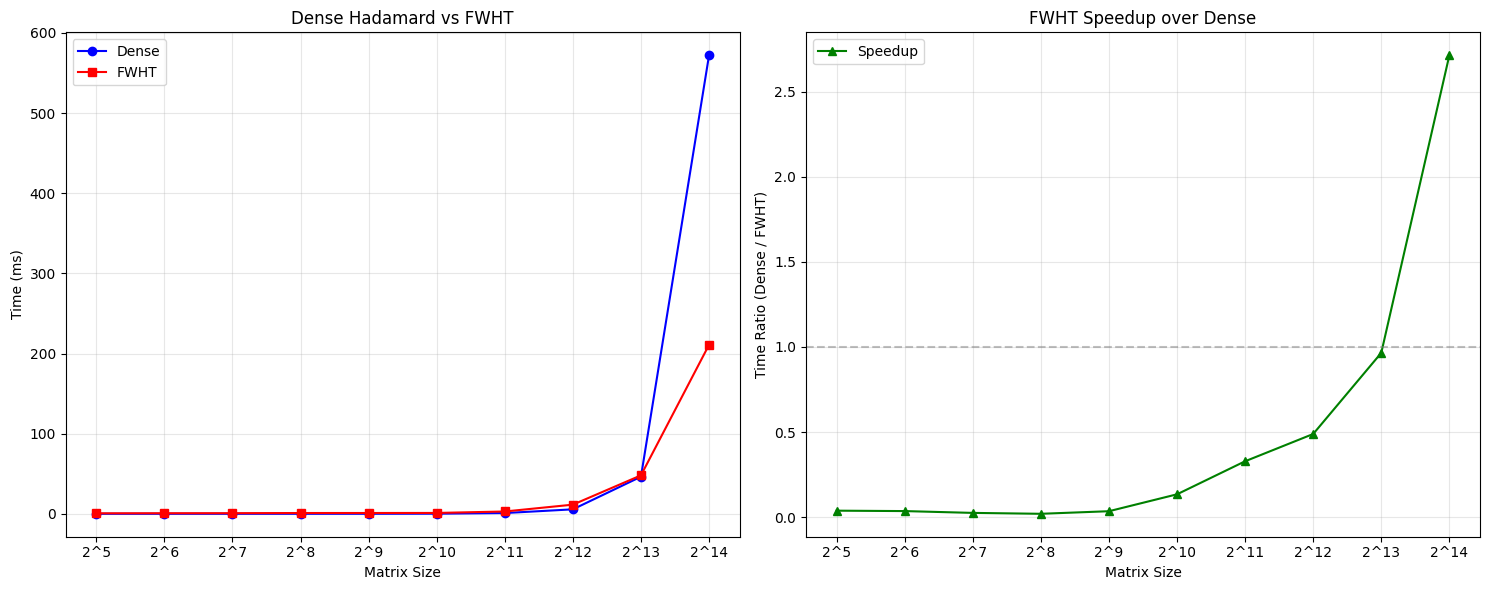

In [12]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np

# FWHT on rows of square matrix
def fwht(X):
    """
    Fast Walsh-Hadamard Transform on each row of a square matrix (N x N),
    where N is a power of two.
    """
    N, N2 = X.shape
    assert N == N2 and (N & (N - 1)) == 0,

    h = 1
    while h < N:
        X = X.view(N, N // (2 * h), 2 * h)
        a = X[:, :, :h]
        b = X[:, :, h:2 * h]
        X[:, :, :h] = a + b
        X[:, :, h:2 * h] = a - b
        X = X.view(N, N)
        h *= 2
    return X

# Config
powers = list(range(5, 15))
matrix_sizes = [2 ** p for p in powers]
num_trials = 50

dense_times = []
fwht_times = []
speedups = []

print(f"{'Matrix Size':<12} {'Dense (ms)':<12} {'FWHT (ms)':<12} {'Speedup':<12} {'FWHT GOPS':<12}")

# Generate Hadamard matrix
def hadamard(n):
    assert n & (n - 1) == 0
    H = torch.tensor([[1.0]], device='cuda', dtype=torch.float16)
    while H.size(0) < n:
        H = torch.cat([torch.cat([H, H], dim=1),
                       torch.cat([H, -H], dim=1)], dim=0)
    return H

# Benchmark
for N in matrix_sizes:
    X = torch.randn(N, N, device="cuda", dtype=torch.float16)
    H = hadamard(N)

    # Warm-up
    for _ in range(5):
        _ = torch.matmul(H, X)
        _ = fwht(X.clone())

    torch.cuda.synchronize()

    # Dense Hadamard timing
    start = time.time()
    for _ in range(num_trials):
        _ = torch.matmul(H, X)
    torch.cuda.synchronize()
    dense_time = (time.time() - start) / num_trials

    # FWHT timing
    start = time.time()
    for _ in range(num_trials):
        _ = fwht(X.clone())
    torch.cuda.synchronize()
    fwht_time = (time.time() - start) / num_trials

    dense_times.append(dense_time * 1000)
    fwht_times.append(fwht_time * 1000)
    speedup = dense_time / fwht_time
    speedups.append(speedup)

    total_flops = N * N * np.log2(N)
    fwht_gops = total_flops / fwht_time / 1e9
    print(f"{N:<12} {dense_time*1000:>10.3f}   {fwht_time*1000:>10.3f}   {speedup:>6.2f}x   {fwht_gops:>8.1f}")

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(powers, dense_times, 'b-o', label='Dense')
ax1.plot(powers, fwht_times, 'r-s', label='FWHT')
ax1.set_xticks(powers)
ax1.set_xticklabels([f'2^{p}' for p in powers])
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Dense Hadamard vs FWHT')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(powers, speedups, 'g-^', label='Speedup')
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax2.set_xticks(powers)
ax2.set_xticklabels([f'2^{p}' for p in powers])
ax2.set_xlabel('Matrix Size')
ax2.set_ylabel('Time Ratio (Dense / FWHT)')
ax2.set_title('FWHT Speedup over Dense')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()
